## Fidelities with Common Randomized Measurements

With common randomized measurements [Vermersch, al, PRXQ 2024](https://doi.org/10.1103/PRXQuantum.5.010352), a classical approximation $\sigma$ of an experimental state $\rho$ is used to facilitate the measurement of physical properties. 

In this tutorial, we will illustrate in the context of the measurement of the fidelity $\mathcal{F}=\mathrm{Tr}(\rho \sigma)$, where $\sigma=\ket{\psi}\bra{\psi}$.

Note that in this example,  $\sigma$ is at the same time the observable we are interested in, and the classical approximation we used for building common randomized measurements.

In [2]:
using ProgressMeter
using ITensors
using RandomMeas

We begin by considering $\sigma=\ket{\psi}\bra{\psi}$ ($\rho$) as the output of a noisy (noiseless, respectively) $2$-qubit quantum circuit of various depths $d$

In [70]:
N = 2
depth = 5
cutoff = 1e-4
ξ = siteinds("Qubit", N)
ψ,ρ,F = MPS[], MPO[], Float64[]

#initial states
push!(ψ,MPS(ξ, ["Dn" for n in 1:N]));
push!(ρ,outer(ψ[1]',ψ[1]));
push!(F,1.)

#random circuit and noise parameters
circuit = random_circuit(ξ,depth)
p = 0.1*rand(N)
@showprogress dt=1 for d in 1:depth
            push!(ψ,apply(circuit,ψ[d];cutoff=cutoff))
            ρt = apply(circuit,ρ[d],apply_dag=true;cutoff=cutoff)
            #each random circuit layer is followed by local depolarization with probabilities p 
            push!(ρ,apply_depo_channel(ρt,p));  

            push!(F,real(inner(ψ[d+1]',ρ[d+1],ψ[d+1])))
end


We first perform randomized measurement on the experimental state, and store the unitaries $u$ that we used

In [71]:
#Perform Randomized measurements
Nu=1000
NM=1000
data = zeros(Int8,(depth+1,Nu,NM,N))
u = Vector{Vector{ITensor}}()
for r in 1:Nu
    push!(u,get_rotations(ξ,1)) #Haar rotations in A
end

for d in 1:depth+1
    @showprogress dt=1 for r in 1:Nu                
                    data[d,r,:,:] = get_RandomMeas(ρ[d],u[r],NM)

    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


From randomized measurement, we know that we can build estimate the fidelity $\mathcal{F}$ as $\mathcal{F}_e=\mathrm{tr}(\sigma \hat{\rho})$ with the shadows $\hat{\rho}$. 

In [72]:
F_e = zeros(Float64,depth+1)
ρr = ITensor(vcat(ξ,ξ'))
#Perform simulated Randomized measurements
for d in 1:depth+1
    ψ_f = flatten(ψ[d])
    @showprogress dt=1 for r in 1:Nu
                    P = get_Born(data[d,r, :,:], ξ)
                    shadow = get_shadow(P, ξ, u[r])
                    ρr += shadow/Nu
                    F_e[d] += real(inner(ψ_f',shadow,ψ_f))/Nu
    end
end

CRM provide a more efficient estimator $\mathcal{F}_{CRM}=\mathrm{tr}(\sigma \hat{\rho})-\mathrm{tr}(\sigma \hat{\sigma})+1$ based on  using the simulated shadow $\hat{\sigma}$, which is generated numerically from the Born probabilities $P_0(s)=\langle s|u\sigma u^\dag|s\rangle$.

In [73]:
F_CRM = copy(F_e).+1
ρr = ITensor(vcat(ξ,ξ'))
#Perform simulated Randomized measurements
for d in 1:depth+1
    ψ_f = flatten(ψ[d])
    @showprogress dt=1 for r in 1:Nu
                    P0 = get_Born(apply(u[r],ψ[d]))
                    shadow_sigma = get_shadow(P0, ξ, u[r])
                    F_CRM[d] -= real(inner(ψ_f',shadow_sigma,ψ_f))/Nu
    end
end

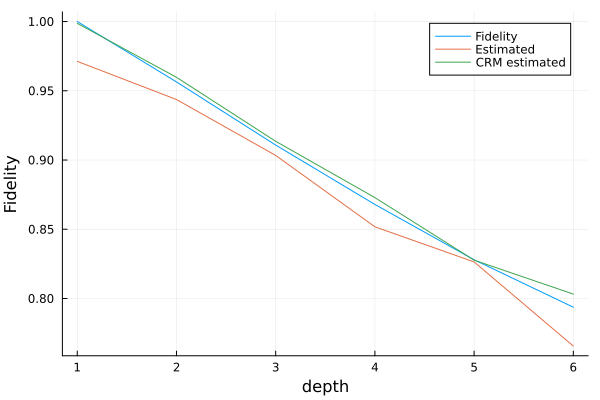

In [74]:
using Plots
Plots.plot(1:depth+1,F,label="Fidelity")
plot!(1:depth+1,F_e,label="Estimated")
plot!(1:depth+1,F_CRM,label="CRM estimated")
xlabel!("depth")
ylabel!("Fidelity")